In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


from convsklearn import barrier_trainer, asian_trainer
from feature_collector import collect_features
price_name = 'barrier_price' 
trainer = barrier_trainer
data_dir = os.path.join(root,ms.bloomberg_spx_barriers['dump'])
dataset = collect_features(data_dir,price_name)



##################
# training start #
##################

Thu Oct 31 20:44:07 2024



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1511/1511 [00:13<00:00, 116.07it/s]


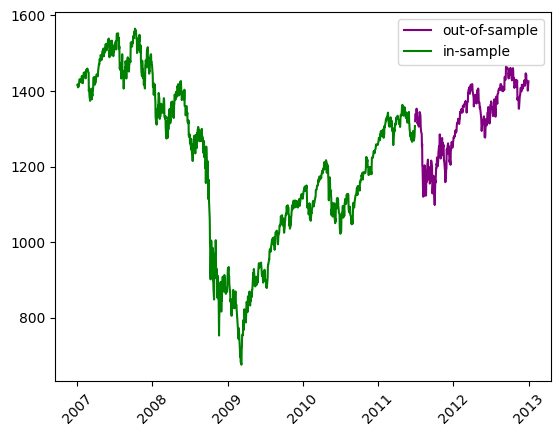

2257961 2257961


In [2]:
dates = pd.Series(np.sort(dataset['calculation_date'].unique()))
development_dates = dates[:len(dates)*3//4]
# development_dates = dates[dates<=pd.Timestamp(2008,9,1)]
test_dates = dates[~dates.isin(development_dates)]
train_data = dataset[dataset['calculation_date'].isin(development_dates)]
test_data = dataset[dataset['calculation_date'].isin(test_dates)]

train_plot = train_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()
test_plot = test_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()
plt.figure()
plt.xticks(rotation=45)
plt.plot(test_plot,color='purple',label='out-of-sample')
plt.plot(train_plot,color='green',label='in-sample')
plt.legend()
plt.show()
arrs = trainer.get_train_test_arrays(
    train_data, test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']
preprocessor = trainer.preprocess()
print(len(train_y),len(train_X))

# need to package the above

## stacked regressor

In [3]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
trainer.dnn_params['max_iter'] = 1000
trainer.dnn_params

{'alpha': 0.01,
 'hidden_layer_sizes': (13, 13),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'solver': 'sgd',
 'early_stopping': False,
 'max_iter': 1000,
 'warm_start': True,
 'tol': 0.0001}

In [4]:
numerical_scaler = QuantileTransformer()
linear_contributors = [
    'spot_price', 'strike_price', 'days_to_maturity', 
    'risk_free_rate', 'dividend_rate', 'kappa', 'theta',
    'v0'
]


ridge_preprocessor = ColumnTransformer(
    transformers=[('scaling', numerical_scaler,linear_contributors)]
)

ridge_pipeline = make_pipeline(ridge_preprocessor, Ridge())

test_ridge = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    transformer=numerical_scaler
)

test_ridge_fit = test_ridge.fit(train_X,train_y)

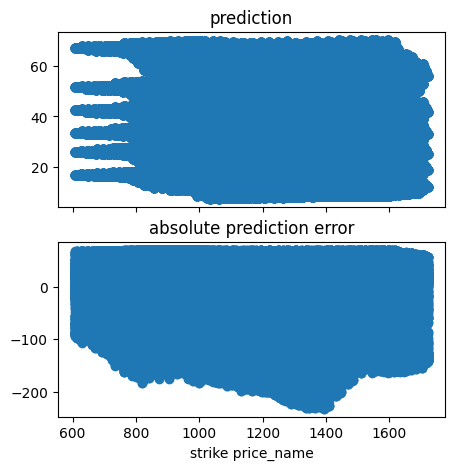


train spots:
calculation_date
2007-01-03    676.03000
2007-01-04    682.43000
2007-01-05    683.09000
2007-01-08    696.44000
2007-01-09    701.13000
                ...    
2011-06-23   1554.55000
2011-06-24   1557.09000
2011-06-27   1561.58000
2011-06-28   1562.09000
2011-06-29   1565.18000
Name: spot_price, Length: 1121, dtype: float64


TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('scaling',
                                                                                       QuantileTransformer(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'v0'])])),
                                                     ('ridge', Ridge())]),
                           transformer=QuantileTransformer())

In [5]:
K = train_X['strike_price'].squeeze().reset_index(drop=True).to_numpy()

predictions = test_ridge_fit.predict(train_X)
diff = predictions-train_y
fig,axs = plt.subplots(2,figsize=(5,5),sharex=True)
axs[0].scatter(K,predictions)
axs[0].set_title('prediction')
axs[1].scatter(K,diff)
axs[1].set_title('absolute prediction error')
plt.xlabel('strike price_name')
plt.show()
spots = train_data['spot_price'].copy().squeeze().sort_values().reset_index(drop=True)
spots.index = train_data['calculation_date']
print(f"\ntrain spots:\n{spots.drop_duplicates()}")
test_ridge

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_scaler,trainer.numerical_features),
        ('categorical',OneHotEncoder(),trainer.categorical_features)
    ]
)

mlp_pipeline = make_pipeline(preprocessor,MLPRegressor())
stacked_regressor = StackingRegressor(estimators=[('dnn',mlp_pipeline),('ridge',ridge_pipeline)])
stacked_regressor

StackingRegressor(estimators=[('dnn',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('numerical',
                                                                                 QuantileTransformer(),
                                                                                 ['spot_price',
                                                                                  'strike_price',
                                                                                  'days_to_maturity',
                                                                                  'risk_free_rate',
                                                                                  'dividend_rate',
                                                                                  'kappa',
                                                                                  'theta',
                                                                                  'rho',
                                                                                  'eta',
                                                                                  'v0',
                                                                                  'barrier']),
                                                                                ('categorical',
                                                                                 OneHotEncoder(),
                                                                                 ['barrier_type_name',
                                                                                  'w'])])),
                                               ('mlpregressor',
                                                MLPRegressor())])),
                              ('ridge',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('scaling',
                                                                                 QuantileTransformer(),
                                                                                 ['spot_price',
                                                                                  'strike_price',
                                                                                  'days_to_maturity',
                                                                                  'risk_free_rate',
                                                                                  'dividend_rate',
                                                                                  'kappa',
                                                                                  'theta',
                                                                                  'v0'])])),
                                               ('ridge', Ridge())]))])

In [ ]:
train_ybar = numerical_scaler.fit_transform(train_y.values.reshape(-1, 1)).ravel()
stacked_regressor.fit(train_X, train_ybar)

# Predict and inverse transform the predictions
predictions_scaled = stacked_regressor.predict(train_X)
predictions = numerical_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()
end = time.time()
runtime = end-train_start

In [ ]:
results = trainer.test_prediction_accuracy(
        stacked_regressor,
        test_data,
        train_data
)

In [ ]:
results

In [ ]:
og = trainer.run_dnn(preprocessor,train_X,train_y)
runtime = end-train_start
insample, outsample, errors = trainer.test_prediction_accuracy(
        og,
        test_data,
        train_data
)
outofsample_RMSE = errors['outofsample_RMSE']

print(f"cpu: {runtime}")
og